In [12]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [14]:
from tiny_model import Net

In [15]:
from architect import Architect

alphas1
alphas2
Train acc 0.7351745735607675
Val acc 0.9117803837953091
Train acc 0.9338019722814499
Val acc 0.9354677505330491
Train acc 0.9505263859275054
Val acc 0.9465951492537313
Train acc 0.957056236673774
Val acc 0.9629864072494669
Train acc 0.9622867803837953
Val acc 0.9626865671641791
Train acc 0.9644856076759062
Val acc 0.9671508528784648
Train acc 0.9686500533049041
Val acc 0.9645855543710021
Train acc 0.9701159381663113
Val acc 0.9695495735607675
Train acc 0.9704824093816631
Val acc 0.9612539978678039
Train acc 0.972547974413646
Val acc 0.9699826759061834
Train acc 0.9739805437100213
Val acc 0.9669509594882729
Train acc 0.9743136993603412
Val acc 0.9709488272921108
Train acc 0.9754797441364605
Val acc 0.970748933901919
Train acc 0.9770455756929638
Val acc 0.9716151385927505
Train acc 0.9771788379530917
Val acc 0.9707822494669509
Train acc 0.9772787846481876
Val acc 0.9710154584221748
Train acc 0.9788779317697228
Val acc 0.9739805437100213
Train acc 0.9789445628997868
Val ac

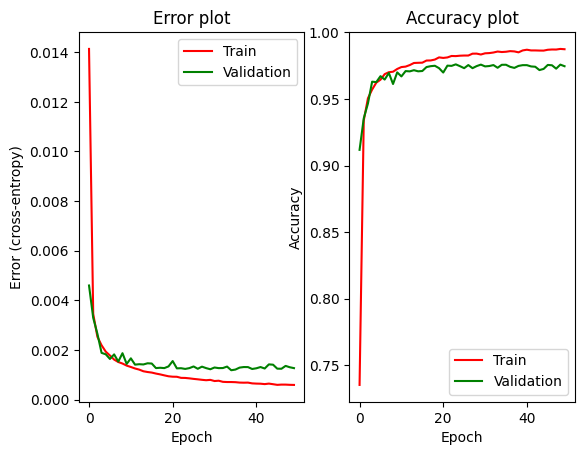

Test accuracy : 0.9803


In [16]:
param_list = []
model = Net(4,4,20,'darts').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)
architect = Architect(model)
optimizer = torch.optim.SGD(param_list,lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    architect.step(images, labels, images_val, labels_val, 0.1, optimizer, unrolled=True)
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
    
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0

print("Test accuracy :",total_acc/len(test_loader.dataset))

In [17]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(9, device='cuda:0')
tensor(13, device='cuda:0')


In [15]:
torch.nn.functional.softmax(model.alphas1,dim=-1)

tensor([0.0644, 0.0364, 0.0378, 0.0954, 0.0336, 0.0246, 0.0827, 0.0614, 0.0799,
        0.0351, 0.0531, 0.0380, 0.0392, 0.1948, 0.1235], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Train acc 0.8133333333333334
Val acc 0.8614527925531915
Train acc 0.9011875
Val acc 0.8912898936170213
Train acc 0.914375
Val acc 0.9193816489361702
Train acc 0.9216458333333334
Val acc 0.9212101063829787
Train acc 0.9272916666666666
Val acc 0.9256150265957447
Train acc 0.9307291666666667
Val acc 0.9287732712765957
Train acc 0.933625
Val acc 0.9274434840425532
Train acc 0.937
Val acc 0.9217918882978723
Train acc 0.9379791666666667
Val acc 0.9327626329787234
Train acc 0.9385208333333334
Val acc 0.9354222074468085
Train acc 0.9406875
Val acc 0.9288563829787234
Train acc 0.9414166666666667
Val acc 0.922124335106383
Train acc 0.9421458333333333
Val acc 0.9316821808510638
Train acc 0.9430208333333333
Val acc 0.9365026595744681
Train acc 0.943375
Val acc 0.9352559840425532
Train acc 0.94375
Val acc 0.9370844414893617
Train acc 0.9447916666666667
Val acc 0.9362533244680851
Train acc 0.94575
Val acc 0.9345910904255319
Train acc 0.9464375
Val acc 0.9371675531914894
Train acc 0.9463125
Val acc 0

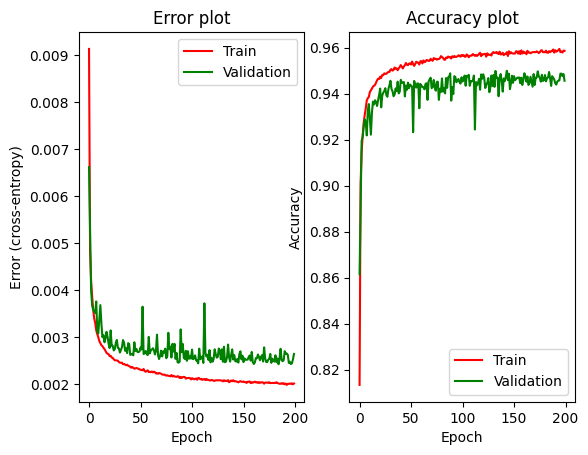

Test accuracy : 0.9538


In [18]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
dict_test_accs = {}
idx1 = 9
idx2 = 13
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(200):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc